In [1]:
# Import the required libraries
import pandas as pd
import networkx as nx

In [2]:
edges_df = pd.read_csv('../data/gephi-edge-list.csv')
nodes_df = pd.read_csv('../data/gephi-node-list.csv')

# Ensure ID columns are clean
nodes_df['ID'] = nodes_df['ID'].astype(str).str.strip()
edges_df['Source'] = edges_df['Source'].astype(str).str.strip()
edges_df['Target'] = edges_df['Target'].astype(str).str.strip()

# Create a mapping from player name to node ID
player_to_id = dict(zip(nodes_df['name'], nodes_df['ID']))


In [3]:
# Initialize graph
G = nx.Graph()

# Add nodes with names as attributes
for _, row in nodes_df.iterrows():
    G.add_node(row['ID'], name=row['name'],college_conference=row['college_conference'])

# Add edges with weights
for _, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

In [4]:
# Compute sum of neighbor edge weights (and use names in output)
sum_neighbor_weights = {}

for node_id in G.nodes():
    neighbors = list(G.neighbors(node_id))
    seen_edges = set()  # To avoid double-counting undirected edges
    total = 0
    
    for neighbor in neighbors:
        for nbr_of_neighbor in G.neighbors(neighbor):
            edge = tuple(sorted([neighbor, nbr_of_neighbor]))
            if edge not in seen_edges:
                total += G[neighbor][nbr_of_neighbor]['weight']
                seen_edges.add(edge)
    
    node_name = G.nodes[node_id]['name']
    sum_neighbor_weights[node_name] = total

# Convert to DataFrame
df = pd.DataFrame(sum_neighbor_weights.items(), columns=["Node", "Sum of Neighbour's Edge Weights"])
print(df)

                Node  Sum of Neighbour's Edge Weights
0     Adam Vinatieri                     48262.125519
1       Jason Peters                         0.000000
2     Terence Newman                     24527.738000
3      DeAngelo Hall                      6889.435667
4       Robbie Gould                      8893.807460
...              ...                              ...
1951   Michael Penix                     75897.802000
1952  Caleb Williams                     95249.109286
1953     Rome Odunze                     95249.109286
1954  Malachi Corley                    101174.800154
1955     Trey Benson                     71622.545000

[1956 rows x 2 columns]


In [5]:
for node_id in G.nodes():
    neighbors = list(G.neighbors(node_id))
    seen_edges = set()  # To avoid double-counting undirected edges
    total = 0
    
    for neighbor in neighbors:
        for nbr_of_neighbor in G.neighbors(neighbor):
            edge = tuple(sorted([neighbor, nbr_of_neighbor]))
            if edge not in seen_edges:
                total += G[neighbor][nbr_of_neighbor]['weight']
                seen_edges.add(edge)
    
    node_name = node_id  # Use node_id directly
    sum_neighbor_weights[node_name] = total

# Convert to DataFrame
sum_neighbor_df = pd.DataFrame(sum_neighbor_weights.items(), columns=["ID", "Sum of Neighbour's Edge Weights"])

# Merge sum_neighbor_df with nodes_df to get college_conference info
final_df = pd.merge(sum_neighbor_df, nodes_df[['ID', 'college_conference']], on='ID', how='inner')

# Group by college_conference and sum the weights
conference_sum = final_df.groupby('college_conference')['Sum of Neighbour\'s Edge Weights'].sum().reset_index()


In [6]:
# Round the 'Sum of Neighbour's Edge Weights' column to 2 decimal places for cleaner display
conference_sum['Sum of Neighbour\'s Edge Weights'] = conference_sum['Sum of Neighbour\'s Edge Weights'].round(2)

# Sort the DataFrame by 'Sum of Neighbour's Edge Weights' in descending order
conference_sum_sorted = conference_sum.sort_values(by='Sum of Neighbour\'s Edge Weights', ascending=False)
conference_sum_sorted = conference_sum_sorted.reset_index(drop=True)

# Print the sorted DataFrame
print(conference_sum_sorted)



                                  college_conference  \
0                            Southeastern Conference   
1                                 Big Ten Conference   
2                          Atlantic Coast Conference   
3                          Pacific Twelve Conference   
4                              Big Twelve Conference   
5                       American Athletic Conference   
6                                     Conference USA   
7                           Mountain West Conference   
8                                        Independent   
9                            Mid-American Conference   
10                               Sun Belt Conference   
11               Missouri Valley Football Conference   
12                                          Big East   
13                            Pacific Ten Conference   
14                                Big Sky Conference   
15                                        Ivy League   
16                     Colonial Athletic Associa

In [7]:
# Calculate mean of neighbors' edge weights per player
mean_neighbor_weights = []

for node_id in G.nodes:
    neighbors = list(G.neighbors(node_id))
    weights = []

    for neighbor in neighbors:
        for nbr_of_neighbor in G.neighbors(neighbor):
            if (neighbor, nbr_of_neighbor) in G.edges:
                weights.append(G[neighbor][nbr_of_neighbor]['weight'])

    node_name = G.nodes[node_id]['name']
    mean_weight = sum(weights) / len(weights) if weights else 0
    mean_neighbor_weights.append({
        'ID': node_id,
        'name': node_name,
        'mean_neighbor_edge_weight': mean_weight
    })

# Merge with nodes_df to get conference info
mean_df = pd.DataFrame(mean_neighbor_weights)
merged_df = pd.merge(mean_df, nodes_df[['ID', 'college_conference']], on='ID', how='left')

# Group by conference and compute mean of means
conference_mean = merged_df.groupby('college_conference')['mean_neighbor_edge_weight'].mean().reset_index()

# Sort into descending order
conference_mean_sorted = conference_mean.sort_values(by='mean_neighbor_edge_weight', ascending=False)

# Save to CSV in same directory as node and edge .csv files
conference_mean_sorted.to_csv('../data/conference_teammate_mean_fantasy_points.csv', index=False)


print(conference_mean_sorted.head())

                              college_conference  mean_neighbor_edge_weight
23               Mid-States Football Association                 132.261676
4             Big South - Ohio Valley Conference                 131.578780
51                   Western Athletic Conference                 129.788326
30                New Jersey Athletic Conference                 128.850535
47  Southern Intercollegiate Athletic Conference                 121.177387


In [26]:
player_stats = []

for node_id in G.nodes():
    neighbors = list(G.neighbors(node_id))
    edge_weights = [G[node_id][neighbor]['weight'] for neighbor in neighbors]
    
    if edge_weights:
        mean_weight = pd.Series(edge_weights).mean()
    else:
        mean_weight = 0

    player_stats.append({
        'ID': node_id,
        'mean_neighbor_edge_weight': mean_weight
    })

player_stats_df = pd.DataFrame(player_stats)

player_stats_df = pd.merge(player_stats_df, nodes_df[['ID', 'college_conference']], on='ID', how='left')

# Group by college_conference to get the mean neighbor edge weight per conference
conference_means = player_stats_df.groupby('college_conference', as_index=False)['mean_neighbor_edge_weight'].mean()

# Calculate the overall mean across all players (not grouped)
overall_mean = player_stats_df['mean_neighbor_edge_weight'].mean()

# Create a summary row
overall_row = pd.DataFrame([{
    'college_conference': 'All Players',
    'mean_neighbor_edge_weight': overall_mean
}])

# Append the row to the grouped DataFrame
conference_means = pd.concat([conference_means, overall_row], ignore_index=True)

# Sort descending by mean
conference_means = conference_means.sort_values(by='mean_neighbor_edge_weight', ascending=False).reset_index()

print(conference_means)

# Save to CSV in same directory as node and edge .csv files
conference_means.to_csv('../data/conference_teammate_means.csv', index=False)

    index                                college_conference  \
0      42                Rocky Mountain Athletic Conference   
1      34                          Ohio Athletic Conference   
2      36                            Pacific Ten Conference   
3      51                       Western Athletic Conference   
4       7                             Big Twelve Conference   
5      44                           Southeastern Conference   
6      47      Southern Intercollegiate Athletic Conference   
7       2                                          Big East   
8       1                         Atlantic Coast Conference   
9      37                         Pacific Twelve Conference   
10     19  Mid-America Intercollegiate Athletic Association   
11      6                                Big Ten Conference   
12     38                                    Patriot League   
13     53                                       All Players   
14     16                                       Indepen

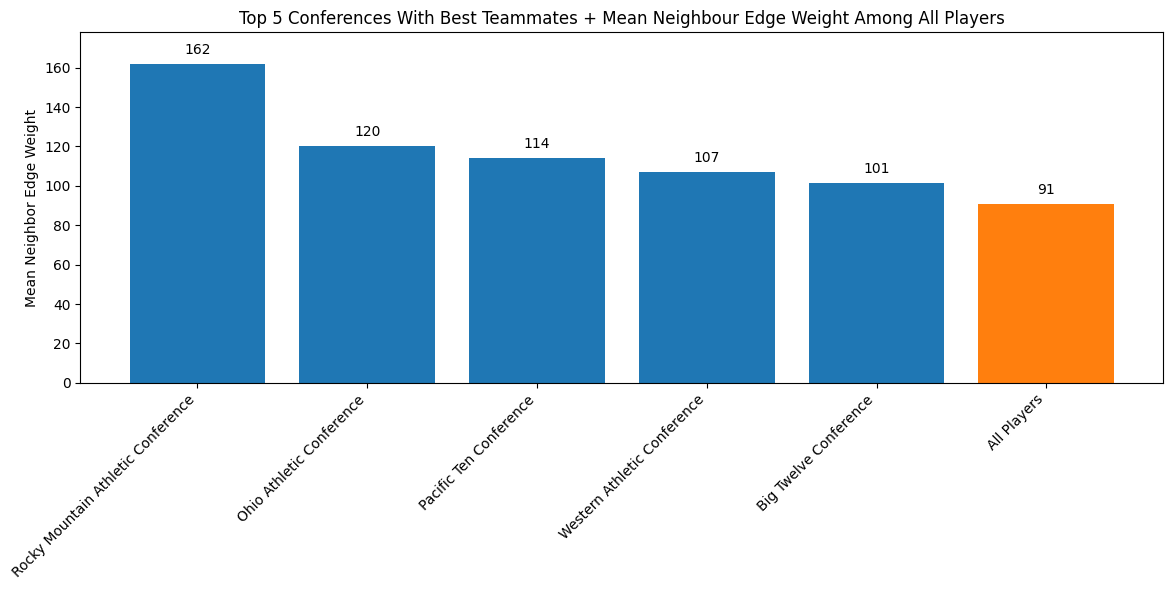

In [27]:
import matplotlib.pyplot as plt

# Sort & select top 5
top5 = conference_means[conference_means['college_conference'] != 'All Players'] \
           .nlargest(5, 'mean_neighbor_edge_weight')

# Select the overall row
overall_row = conference_means[conference_means['college_conference'] == 'All Players']

# Combine for plotting
plot_df = pd.concat([top5, overall_row])

# Plot
plt.figure(figsize=(12, 6))
colors = ['#1f77b4'] * len(top5) + ['#ff7f0e']  # Highlight 'overall' in orange
bars = plt.bar(plot_df['college_conference'], plot_df['mean_neighbor_edge_weight'], color=colors)

# Calculate the max height + padding for better label space
max_height = plot_df['mean_neighbor_edge_weight'].max()
plt.ylim(0, max_height * 1.1)  # Add 10% padding above the tallest bar

# Annotate
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:,.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords="offset points",
                 ha='center', va='bottom')

# Labels & formatting
plt.title('Top 5 Conferences With Best Teammates + Mean Neighbour Edge Weight Among All Players')
plt.ylabel('Mean Neighbor Edge Weight')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()